## League of Legends Competitive Analysis
    
    by Varun Nadgir

### The Goal

Using the competitive League of Legends match data provided by [Oracle's Elixir](http://oracleselixir.com/match-data/), I will be looking for trends in 'Champion' performance and regional playstyles, among other interesting findings I might come across. The idea is to put myself in the shoes of a professional gaming organization's analyst and try to find ways to give "our" team the edge against an opposing team. This would be particularly useful in international tournaments, when teams that never meet during the regular season challenge each other for the first time.

### The Data

The dataset consists of about 15,000 rows and almost 100 columns. Each game contains 12 rows - 5 for the players on one team, 5 for the other, and 2 for overall team averages. The first few columns are shared values, such as 'gameid', 'league', 'split', 'date' and other meta information regarding the game that was played, while the rest of the columns are in-game values, such as the 'Champion' picked and other performance factors. These data are taken from the 2018 Spring Split from each of the global regions - although we are in the middle of the 2018 Summer Split, I wanted to use a complete dataset.

### Goals

One of the first questions I was interested in exploring was "How do these Champions fare against each other?" This meant the most important variables for this question were the 'champion' and 'result' columns, so I began by shrinking the original dataset down to just containing the information about the region the game was played in, which of the five positions the Champion was played in, and whether or not they won that specific matchup. During this time, I realized that, unfortunately, not all of the 'gameid' values were unique, since some were duplicated across leagues. For now, I chose to separate the champion matchups by region, but one of the next steps will be to combine them. This would help teams when preparing for new competition - after scouting out the Champions they like to play, one could think of potential counters.

My second question *would* require some in-game values - "Does having a lead at the 10-15 minute mark lead to wins?" The concept of "snowballing" a lead is a common one in League of Legends, yet some teams still find ways to come back through defensive play or by exploiting a single mistake of the enemy team. This question can also be explored through multiple avenues, such as first blood rate, gold lead, and/or turret/objective lead. In this case, it would be good to split up the dataset by region, since it is commonly accepted that the Korean league is of the highest quality, while the North American league is of lower quality. It would be interesting to see if leads *do* become wins in Korea but that they have no correlation in North America.

### Importing Data

In [4]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

# remove assignment warning for later step
pd.options.mode.chained_assignment = None  # default='warn'

# read in csv
loldf = pd.read_csv('loldata.csv')

C:\Users\FKBOX\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Champion Head-to-Head Performance

### LCK 

To begin, I subsetted the data to only include the Korean league data. This keeps the data small and allows me to test the quality of the code before expanding.




In [5]:
# filter out specific columns needed
df = loldf[['gameid', 'league', 'position', 'team', 'champion', 'result']]
# list of unique gameid in the entire dataset
gamelist = df['gameid'].unique()

# subset data to just the LCK league (Korean)
lck = df[df['league']=='LCK']
# list of unique gameid from just the LCK
lck_gamelist = lck['gameid'].unique()

# subset the dataset to be separated by player position
top = df[df['position']=='Top']
jungle = df[df['position']=='Jungle']
middle = df[df['position']=='Middle']
ADC = df[df['position']=='ADC']
support = df[df['position']=='Support']

# subset the dataset to only include LCK Top champions
lck_top = lck[lck['position']=='Top']

In [7]:
# create groupby object based on 'gameid', each item contains winner and loser of the game
lck_group = lck_top.groupby('gameid')[['champion', 'result']]

# create a square matrix of 0's with rows/columns equal to number of unique champions picked
matrix = pd.DataFrame(0, index=lck_top['champion'].unique(), columns=lck_top['champion'].unique())

# loop through each unique gameid and add a 1 to each cell location where the ROW defeats the COLUMN
for i in range(len(lck_gamelist)):
    group_champs = lck_group.get_group(lck_gamelist[i]).sort_values('result', ascending=False)['champion']
    win_champ = group_champs.iloc[0]
    lose_champ = group_champs.iloc[1]
    matrix[lose_champ].loc[win_champ] += 1

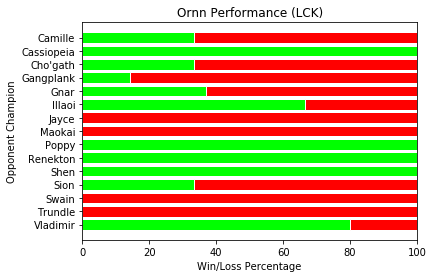

In [8]:
# make list of all unique champions picked
lcktop_champs = lck_top['champion'].unique()

# create empty lists for later
opponents = []
wins = []
losses = []

# store name of champion (select from 0 - 25)
champ = lcktop_champs[0]
# for each opponent in list of unique champs, add num wins and num losses to respective lists, record name of opponent
# skip those opponents with 0 wins and 0 losses (meaning they never met in-game)
for opp_champ in sorted(lcktop_champs, reverse=True):
    winSide = matrix.at[champ, opp_champ]
    lossSide = matrix.at[opp_champ, champ]
    if ((winSide+lossSide) > 0):
        wins.append(matrix.at[champ, opp_champ])
        losses.append(matrix.at[opp_champ, champ])
        opponents.append(opp_champ)

# create dataframe of wins/losses to be plotted
data = {'greenBars': wins, 'redBars': losses}
winrate_df = pd.DataFrame(data)

# calculate percentages of wins and losses vs each champion
totals = [x+y for x,y in zip(winrate_df['greenBars'], winrate_df['redBars'])]
greenBars = [x/y*100 for x,y in zip(winrate_df['greenBars'], totals)]
redBars = [x/y*100 for x,y in zip(winrate_df['redBars'], totals)]

# create horizontal bar plot to show performance vs everyone else
plt.barh(opponents, greenBars, edgecolor='white', color='#00ff00')
plt.barh(opponents, redBars, edgecolor='white', color='#ff0000', left=greenBars)

# label axes and show plot
plt.title(champ +" Performance (LCK)")
plt.xlabel('Win/Loss Percentage')
plt.ylabel('Opponent Champion')

plt.show()

### All Major Regions

After completing the code for just LCK, it became possible to expand to all 5 major regions (North America, Europe, Southeast Asia, China, and Korea).

In [9]:
# apply same logic for all regions
major_regions = df[df['league'].isin(['NALCS', 'EULCS', 'LCK', 'LPL', 'LMS'])]
major_regions_top = major_regions[major_regions['position']=='Top']
major_regions_gamelist = major_regions['gameid'].unique()

In [10]:
# create groupby object based on 'gameid', each item contains winner and loser of the game
major_group = major_regions_top.groupby('gameid')[['champion', 'result']]

# create a square matrix of 0's with rows/columns equal to number of unique champions picked
major_matrix = pd.DataFrame(0, index=major_regions_top['champion'].unique(), columns=major_regions_top['champion'].unique())

# loop through each unique gameid and add a 1 to each cell location where the ROW defeats the COLUMN
for i in range(len(major_regions_gamelist)):
    major_group_champs = major_group.get_group(major_regions_gamelist[i]).sort_values('result', ascending=False)['champion']
    win_champ = major_group_champs.iloc[0]
    lose_champ = major_group_champs.iloc[1]
    major_matrix[lose_champ].loc[win_champ] += 1

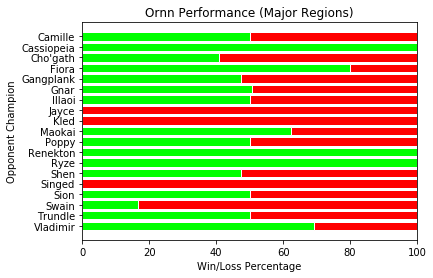

In [11]:
# make list of all unique champions picked
major_region_champs = major_regions_top['champion'].unique()

# create empty lists for later
opponents = []
wins = []
losses = []

# store name of champion (select from 0 - 32)
champ = major_region_champs[0]
# for each opponent in list of unique champs, add num wins and num losses to respective lists, record name of opponent
# skip those opponents with 0 wins and 0 losses (meaning they never met in-game)
for opp_champ in sorted(major_region_champs, reverse=True):
    winSide = major_matrix.at[champ, opp_champ]
    lossSide = major_matrix.at[opp_champ, champ]
    if ((winSide+lossSide) > 0):
        wins.append(major_matrix.at[champ, opp_champ])
        losses.append(major_matrix.at[opp_champ, champ])
        opponents.append(opp_champ)

# create dataframe of wins/losses to be plotted
data = {'greenBars': wins, 'redBars': losses}
winrate_df = pd.DataFrame(data)

# calculate percentages of wins and losses vs each champion
totals = [x+y for x,y in zip(winrate_df['greenBars'], winrate_df['redBars'])]
greenBars = [x/y*100 for x,y in zip(winrate_df['greenBars'], totals)]
redBars = [x/y*100 for x,y in zip(winrate_df['redBars'], totals)]

# create horizontal bar plot to show performance vs everyone else
plt.barh(opponents, greenBars, edgecolor='white', color='#00ff00')
plt.barh(opponents, redBars, edgecolor='white', color='#ff0000', left=greenBars)

# label axes and show plot
plt.title(champ +" Performance (Major Regions)")
plt.xlabel('Win/Loss Percentage')
plt.ylabel('Opponent Champion')

plt.show()

### Hypothesis Testing

